# 설정

In [3]:
# 파이썬 ≥ 3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥ 0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 회귀 실습 - 캐글 주택 가격: 고급 회귀 기법

이번 실습은 캐글에서 제공하는 캐글 주택 가격: 고급 회귀 기법(House Price: Advanced Regression Techniques) 데이터 세트를 이용해 회귀 분석을 더 심층적으로 학습해 보겠다.

79개의 특성으로 구성된 이 데이터는 미국 아이오와 주의 에임스(Ames) 지방의 주택 가격 정보를 가지고 있다. 성능 평가는 RMSLE(Root Mean Squared Log Error)를 기반으로 한다. 가격이 비싼 주택일수록 예측 결과 오류가 전체 오류에 미치는 비중이 높으므로 이것을 상쇄하기 위해 오류 값을 로그 변환한 RMSLE를 이용한다.

## 데이터 사전 처리(Preprocessing)

먼저 필요한 모듈과 데이터를 로딩하고 개략적으로 데이터를 확인해 보겠다. 이 예제는 데이터 가공을 많이 수행할 예정이므로 원본 csv 파일 기반의 DataFrame은 보관하고 복사해서 데이터를 가공하겠다.

In [20]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('./house-prices-advanced-regression-techniques/train.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


Target 값은 맨 마지막 칼럼인 SalePrice이다. 데이터 세트의 전체 크기와 칼럼의 타입, 그리고 Null이 있는 칼럼과 그 건수를 내림차순으로 출력해 보겠다.

In [21]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 피처의 type \n', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 칼럼과 그 건수:\n', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

전체 피처의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 칼럼과 그 건수:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


데이터 세트는 1460개의 레코드와 81개의 피처로 구성돼 있으며, 피처의 타입은 숫자형은 물론 문자형도 많이 있다. Target을 제외한 80개의 피처 중 43개가 문자형이며 나머지가 숫자형이다. 데이터 양에 비해 Null 값이 많은 피처도 있다. 전체 1480개 데이터 중 PoolQC, MiscFeature, Alley, Fence는 1000개가 넘는 데이터가 Null이다. Null 값이 너무 많은 피처는 드롭하겠다.

회귀 모델을 적용하기 전에 타깃 값의 분포도가 정규 분포인지 확인하겠다. 다음 그림에서 볼 수 있듯이 데이터 값의 분포가 중심에서 왼쪽으로 치우친 형태로, 정규 분포에서 벗어나 있다.

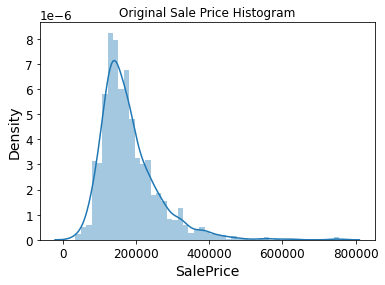

In [22]:
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice']);

정규 분포가 아닌 결괏값을 정규 분포 형태로 변환하기 위해 로그 변환<sup>Log Transformation</sup>을 적용하겠다. 먼저 넘파이의 <code>log1p()</code>를 이용해 로그 변환한 결괏값을 기반으로 학습한 뒤, 예측 시에는 다시 결괏값을 <code>expm1()</code>으로 추후에 환원하면 된다. 결괏값을 로그 변환하고 다시 분포도를 살펴보겠다.

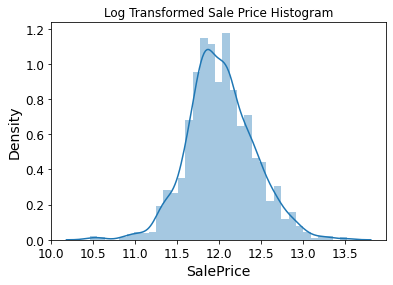

In [23]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice);

SalePrice를 로그 변환해 정규 분포 형태로 결괏값이 분포함을 확인할 수 있다. 이제 SalePrice를 로그 변환한 뒤 DataFrame에 반영하겠다.

그리고 Null 값이 많은 피처인 PoolQC, MiscFeature, Alley, Fence, FireplaceQu는 삭제하겠다. 또한 Id도 단순 식별자이므로 삭제하겠다. LotFrontage는 Null이 259개로 비교적 많으나 평균값으로 대체하겠다. 그리고 나머지 Null 피처는 Null 값이 많지 않으므로 숫자형의 경우 평균값으로 대체하겠다.

위의 로그 변환 및 Null 피처의 전처리를 수행해 보겠다. DataFrame 객체의 <code>mean()</code> 메서드는 자동으로 숫자형 칼럼만 추출해 칼럼별 평균값을 Series 객체로 반환해준다. 따라서 다음 코드의 <code>DataFrame.fillna(DataFrame.mean())</code>은 결과적으로 Null 값인 숫자형 피처만 평균값으로 대체해준다.

In [24]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null이 너무 많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1,
              inplace=True)
# 드롭하지 않는 숫자형 Null 칼럼은 평균값으로 대체
house_df.fillna(house_df.mean(), inplace=True)

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


이제 문자형 피처를 제외하고는 Null 값이 없다. 문자형 피처는 모두 원-핫 인코딩으로 변환하겠다. 원-핫 인코딩은 판다스의 <code>get_dummies()</code>를 이용하겠다. <code>get_dummies()</code>는 자동으로 문자열 피처를 원-핫 인코딩 변환하면서 Null 값은 'None' 칼럼으로 대체해주기 때문에 별도의 Null 값을 대체하는 로직이 필요 없다. 원-핫 인코딩을 적용하면 당연히 칼럼이 증가한다. 변환 후 얼마나 칼럼이 늘어났는지 확인해 보겠다.

In [27]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type: \n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 271)
## Null 피처의 Type: 
 Series([], dtype: object)


원-핫 인코딩 후 피처가 75개에서 272개로 증가했다. 그리고 Null 값을 가진 피처는 이제 존재하지 않는다. 이 정도에서 데이터 세트의 기본적인 가공은 마치고 회귀 모델을 생성해 학습한 후 예측 결과를 평가해 보겠다. 먼저 데이터 세트를 학습과 테스트 데이터 세트로 분할해 사이킷런의 LinearRegression, Ridge, Lasso를 이용해 선형 계열의 회귀 모델을 만들어 보겠다.

## 선형 회귀 모델 학습/예측/평가

앞에서 예측 평가는 RMSLE(즉, 실제 값과 예측값의 오류를 로그 변환한 뒤 RMSE를 적용)를 이용한다고 말했다. 그런데 이미 타깃 값인 SalePrice가 로그 변환됐다. 예측값 역시 로그 변환된 SalePrice 값을 기반으로 예측하므로 원본 SalePrice 예측값의 로그 변환 값이다. 실제 값도 로그 변환됐고, 예측값도 이를 반영한 로그 변환 값이므로 예측 결과 오류에 RMSE만 적용하면 RMSLE가 자동으로 측정된다(원래 캐글에서는 실제 값의 로그 변환된 값과 이에 기반한 예측값을 RMSE로 평가하도록 제시했다. 이에 대한 표현을 앞에서 RMSLE로 대체한 것이다).

여러 모델의 로그 변환된 RMSE를 측정할 것이므로 이를 계산하는 함수를 먼저 생성하겠다.

In [29]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, ' 로그 변환된 RMSE:', np.round(rmse, 3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

<code>get_rmse(model)</code>은 단일 모델의 RMSE 값을, <code>get_rmses(models)</code>는 <code>get_rmse()</code>를 이용해 여러 모델의 RMSE 값을 반환한다. 이제 선형 회귀 모델을 학습하고 예측, 평가해 보겠다.

In [32]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop(['SalePrice'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2,
                                                    random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
models_rmse = get_rmses(models)

LinearRegression  로그 변환된 RMSE: 0.132
Ridge  로그 변환된 RMSE: 0.128
Lasso  로그 변환된 RMSE: 0.176


라쏘 회귀의 경우 회귀 성능이 타 회귀 방식보다 많이 떨어지는 결과가 나왔다. 라쏘의 경우 최적 하이퍼 파라미터 튜닝이 필요해 보인다. 조금 있다가 alpha 하이퍼 파라미터 최적화를 릿지와 라쏘 모델에 대해서 수행하겠다. 그보다 먼저 피처별 회귀 계수를 시각화해서 모델별로 어떠한 피처의 회귀 계수로 구성되는지 확인해 보겠다. 피처가 많으니 회귀 계수 값의 상위 10개, 하위 10개의 피처명과 그 회귀 계수 값을 가지는 판다스 Series 객체를 반환하는 함수를 만들겠다.

In [33]:
def get_top_bottom_coef(model, n=10):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 칼럼명
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개, - 하위 10개의 회귀 계수를 추출해 반환.
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

생성한 <code>get_top_bottom_coef(model, n=10)</code> 함수를 이용해 모델별 회귀 계수를 시각화한다. 시각화를 위한 함수로 <code>visualize_coefficient(models)</code>를 생성한다. 해당 함수는 list 객체로 모델을 입력 맏아 모델별로 회귀 계수 상위 10개, 하위 10개를 추출해 가로 막대 그래프 형태로 출력한다.

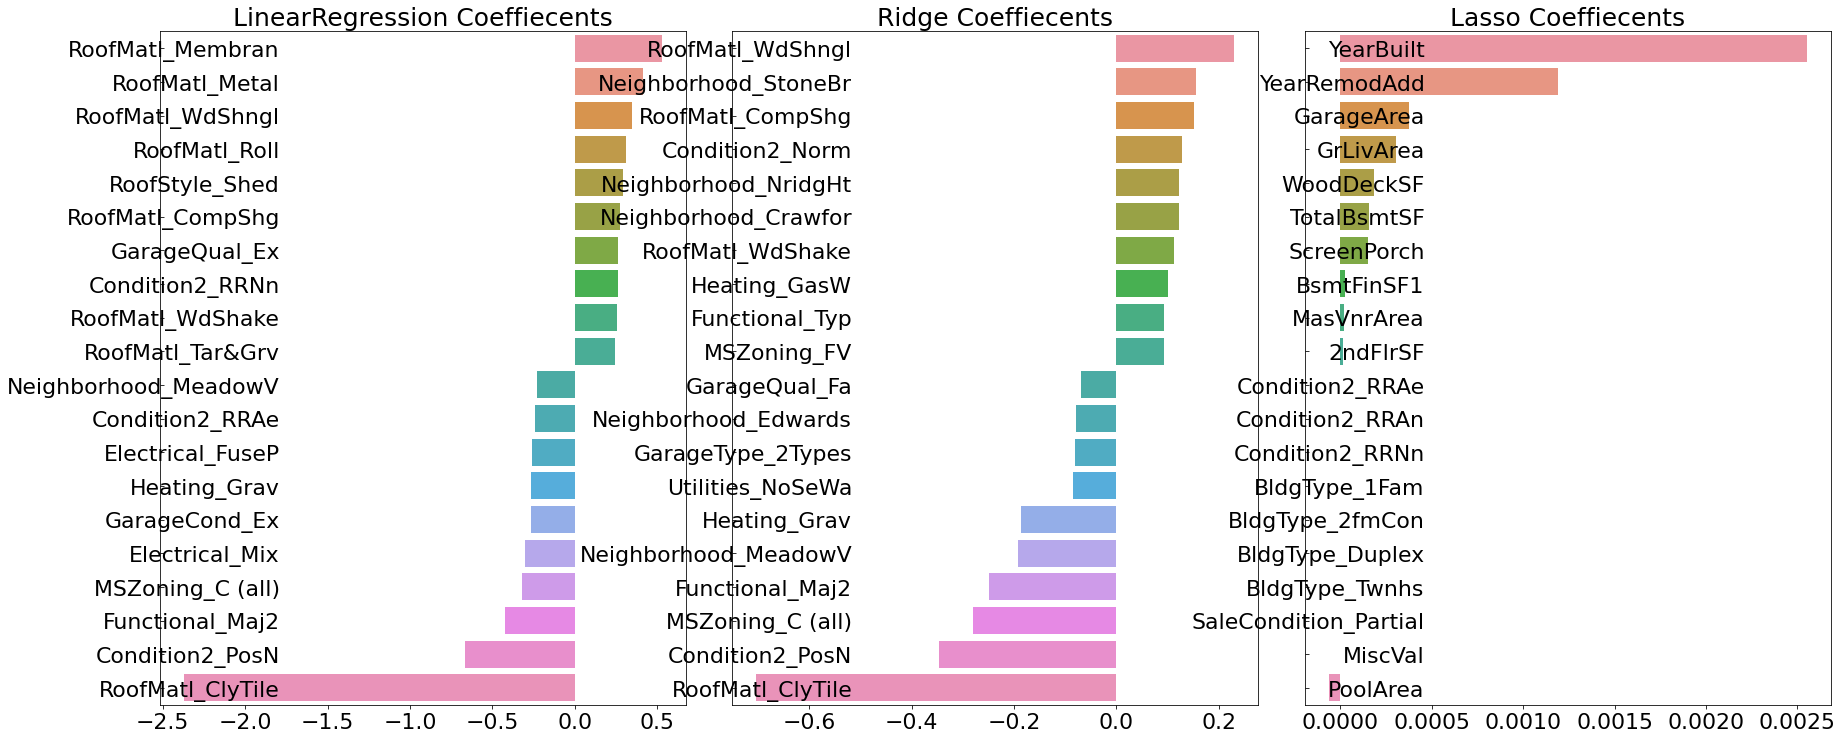

In [38]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
    fig.tight_layout()
    # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화.
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        # ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정.
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y", direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])
        
# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

모델별 회귀 계수를 보면 OLS 기반의 LinearRegression과 Ridge의 경우는 회귀 계수가 유사한 형태로 분포돼 있다. 하지만 라쏘<sup>Lasso</sup>는 전체적으로 회귀 계수 값이 매우 작고, 그중에 YearBuilt가 가장 크고 다른 피처의 회귀 계수는 너무 작다. 라쏘의 경우 다른 두 개의 모델과 다른 회귀 계수 형태를 보이고 있다. 혹시 학습 데이터의 데이터 분할에 문제가 있어서 그런 것인지, 이번에는 학습과 테스트 데이터 세트를 <code>train_test_split()</code>로 분할하지 않고 전체 데이터 세트인 X_features와 y_target을 5개의 교차 검증 폴드 세트로 분할해 평균 RMSE로 측정해 보겠다. 이를 위해 <code>cross_val_score()</code>를 이용한다.

In [40]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score() 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring='neg_mean_squared_error', cv=5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))
        
# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE 값 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155

Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


5개의 폴드 세트로 학습한 후 평가해도 여전히 라쏘의 경우가 OLS 모델이나 릿지 모델보다 성능이 떨어진다. 릿지와 라쏘 모델에 대해서 alpha 하이퍼 파라미터를 변화시키면서 최적 값을 도출해 보겠다. 먼저 앞으로 모델별로 최적화 하이퍼 파라미터 작업을 반복적으로 진행하므로 이를 위한 별도의 함수를 생성하겠다. <code>print_best_params(model, params)</code>는 모델과 하이퍼 파라미터 딕셔너리 객체를 받아 최적화 작업의 결과를 표시하는 함수다. 이 함수를 이용해 릿지 모델과 라쏘 모델의 최적화 alpha 값을 추출하겠다.

In [42]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                       np.round(rmse, 4), grid_model.best_params_))
    
ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값:0.142, 최적 alpha:{'alpha': 0.001}


릿지 모델의 경우 alpha가 12에서 최적 평균 RMSE가 0.1418, 라쏘 모델의 경우 alpha가 0.001에서 최적 평균 RMSE가 0.142이다. 라쏘 모델의 경우, alpha 값 최적화 이후 예측 성능이 많이 좋아졌다. 선형 모델에 최적 alpha 값을 설정한 뒤, <code>train_test_split()</code>으로 분할된 학습 데이터와 테스트 데이터를 이용해 모델의 학습/예측/평가를 수행하고, 모델별 회귀 계수를 시각화해 보겠다.

LinearRegression  로그 변환된 RMSE: 0.132
Ridge  로그 변환된 RMSE: 0.124
Lasso  로그 변환된 RMSE: 0.12


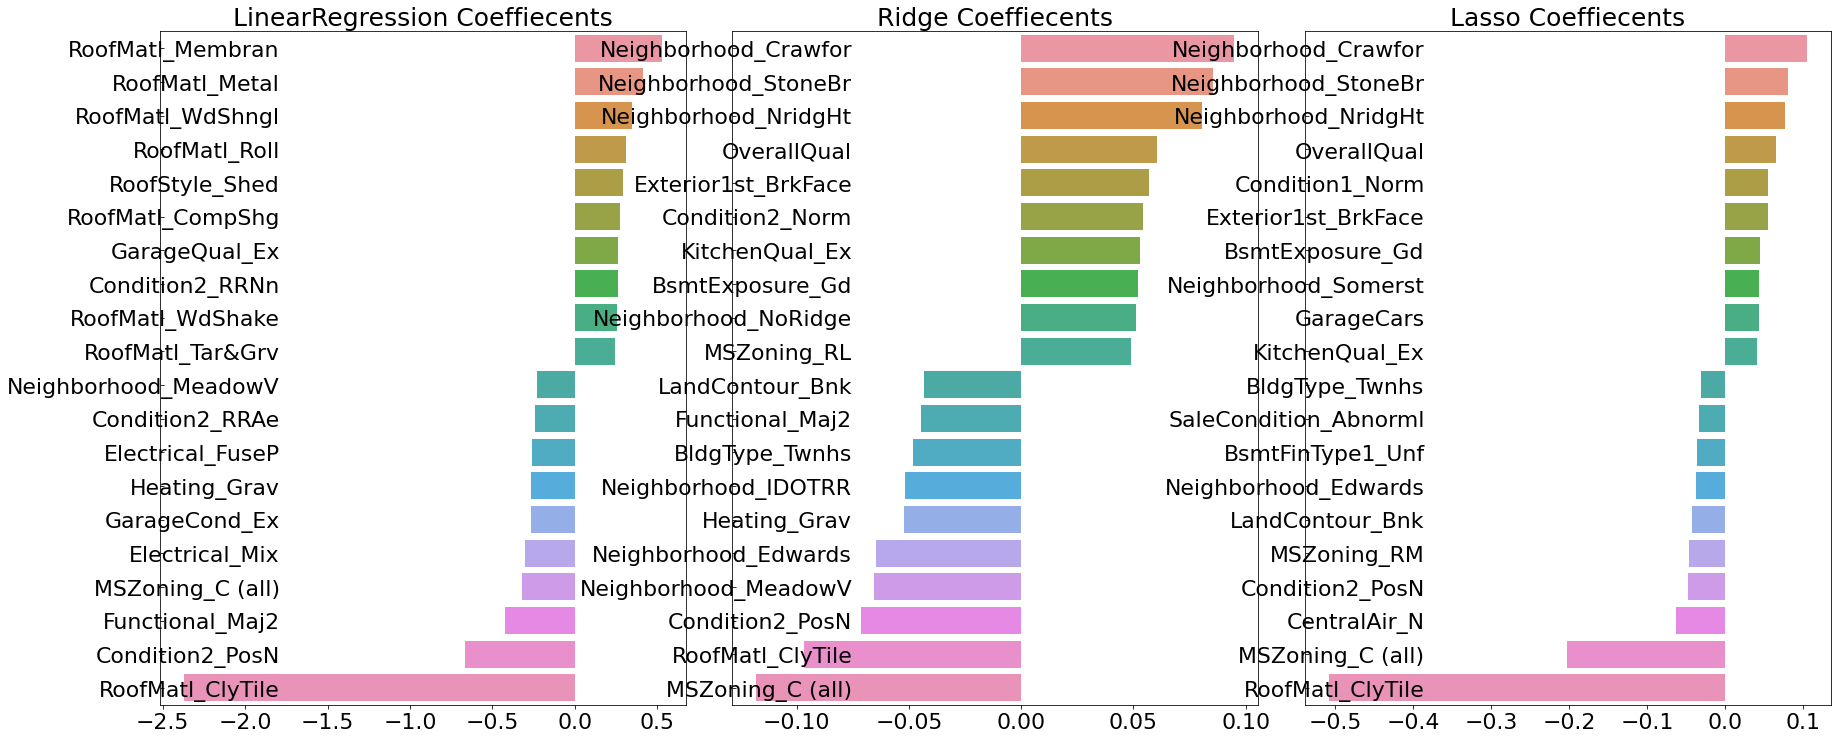

In [43]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
visualize_coefficient(models)

alpha 값 최적화 후 테스트 데이터 세트의 예측 성능이 더 좋아졌다. 모델별 회귀 계수도 많이 달라 졌다. 기존에는 라쏘 모델의 회귀 계수가 나머지 두 개 모델과 많은 차이가 있었지만, 이번에는 릿지와 라쏘 모델에서 비슷한 피처의 회귀 계수가 높다. 다만 라쏘 모델의 경우는 릿지에 비해 동일한 피처라도 회귀 계수의 값이 상당히 작다.

데이터 세트를 추가적으로 가공해서 모델 튜닝을 좀 더 진행해 보겠다. 두 가지를 살펴볼 텐데, 첫 번째는 피처 데이터 세트의 데이터 분포도이고 두 번째는 이상치<sup>Outlier</sup> 데이터 처리다. 먼저 피처 데이터 세트의 분포도를 확인한다.

앞에서 타깃 데이터 세트의 데이터 분포도의 왜곡을 확인했다. 피처 데이터 세트의 경우도 지나치게 왜곡된 피처가 존재할 경우 회귀 예측 성능을 저하시킬 수 있다. 모든 숫자형 피처의 데이터 분포도를 확인해 분포도가 어느 정도로 왜곡됐는지 알아보겠다.

사이파이 stats 모듈의 <code>skew()</code> 함수를 이용해 칼럼의 데이터 세트의 왜곡된 정도를 쉽게 추출할 수 있다. DataFrame에서 숫자형 피처의 왜곡 정도를 확인해 보겠다. 일반적으로 <code>skew()</code> 함수의 반환 값이 1이상인 경우를 왜곡 정도가 높다고 판단하지만 상황에 따라 편차는 있다. 여기서는 1이상의 값을 반환하는 피처만 추출해 왜곡 정도를 완화하기 위해 로그 변환을 적용하겠다. 다음 예제 코드에서는 숫자형 피처의 칼럼 index 객체를 추출해 구한 숫자형 칼럼 데이터 세트의 <code>apply lambda</code> 식 <code>skew()</code>를 호출해 숫자형 피처의 왜곡 정도를 구한다.

여기서 한 가지 주의할 점이 있다. <code>skew()</code>를 적용하는 숫자형 피처에서 원-핫 인코딩된 카테고리 숫자형 피처는 제외해야 한다. 카테고리 피처는 코드성 피처이므로 인코딩 시 당연히 왜곡될 가능성이 높다(예를 들어 '화장실 여부'가 1로 1000건, 0으로 10건이 될 수 있지만, 이는 왜곡과는 무관하다). 따라서 <code>skew()</code> 함수를 적용하는 DataFrame은 원-핫 인코딩이 적용된 house_df_ohe가 아니라 원-핫 인코딩이 적용되지 않은 house_df이어야 한다.

In [50]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 칼럼 index를 []로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew() 호출
skew_features = house_df[features_index].apply(lambda x : skew(x))
# skew(왜곡) 정도가 1 이상인 칼럼만 추출.
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


이제 추출된 왜곡 정도가 높은 피처를 로그 변환한다.

In [51]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

로그 변환 후 이 피처들의 왜곡 정도를 다시 확인해 보면 여전히 높은 왜곡 정도를 가진 피처가 있지만, 더 이상 로그 변환을 하더라도 개선하기는 어렵기에 그대로 유지한다. house_df의 피처를 일부 로그 변환했으므로 다시 원-핫 인코딩을 적용한 house_df_ohe를 만들겠다. 그리고 이에 기반한 피처 데이터 세트와 타깃 데이터 세트, 학습/테스트 데이터 세트를 모두 다시 만들겠다. 그리고 이렇게 만든 데이터 세트에 다시 앞에서 생성한 <code>print_best_params()</code> 함수를 이용해 최적 alpha 값과 RMSE를 출력해 보겠다.

In [55]:
# 왜곡 정도가 높은 피처를 로그 변환했으므로 다시 원-핫 인코딩을 적용하고 피처/타깃 데이터 세트 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop(['SalePrice'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2,
                                                    random_state=156)

# 피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1275, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1252, 최적 alpha:{'alpha': 0.001}


릿지 모델의 경우 최적 alpha값이 12에서 10으로 변경됐고, 두 모델 모두 피처의 로그 변환 이전과 비교해 릿지의 경우 0.1418에서 0.1275로, 라쏘의 경우 0.142에서 0.1252로, 5 폴드 교차 검증의 평균 RMSE값이 향상됐다. 다시 위의 <code>train_test_split()</code>으로 분할된 학습 데이터와 테스트 데이터를 이용해 모델의 학습/예측/평가 및 모델별 회귀 계수를 시각화하면 결과는 다음과 같다. 회귀 계수 시각화 결과를 보면 세 모델 모두 GrLivArea, 즉 주거 공간 크기가 회귀 계수가 가장 높은 피처가 됐다. 주거 공간의 크기가 주택 가격에 미치는 영향이 당연히 제일 높을 것이라는 상식선에서의 결과가 이제야 도출됐다.

LinearRegression  로그 변환된 RMSE: 0.128
Ridge  로그 변환된 RMSE: 0.122
Lasso  로그 변환된 RMSE: 0.119


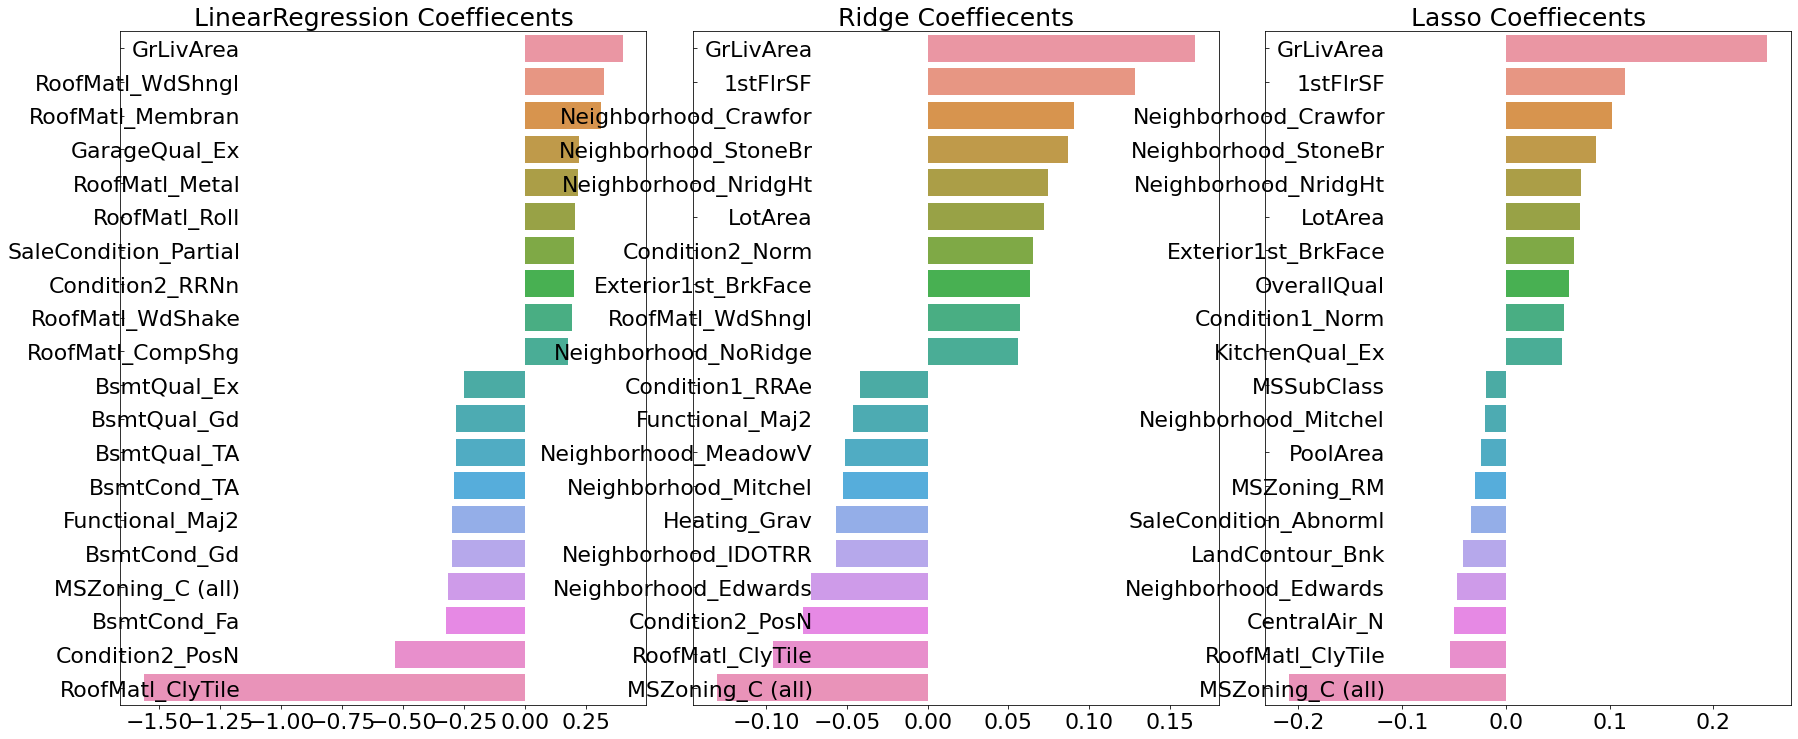

In [58]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
visualize_coefficient(models)

다음으로 좀 더 분석할 요소는 이상치 데이터다. 특히 회귀 계수가 높은 피처, 즉 예측에 많은 영향을 미치는 중요 피처의 이상치 데이터의 처리가 중요하다. 먼저 세 개 모델 모두에서 가장 큰 회귀 계수를 가지는 GrLivArea 피처의 데이터 분포를 살펴보겠다.

주택 가격 데이터가 변환되기 이전의 원본 데이터 세트인 house_df_org에서 GrLivArea와 타깃 값의 SalePrice의 관계를 시각화해 보겠다.

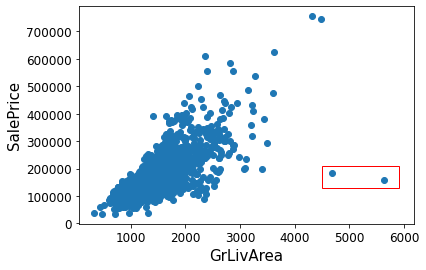

In [104]:
import matplotlib.patches as patches

plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
shp = patches.Rectangle((4500, 130000), 1400, 80000, fill=False, edgecolor='red')
plt.gca().add_patch(shp)
plt.show()

일반적으로 주거 공간이 큰 집일수록 가격이 비싸기 때문에 GrLivArea 피처는 SalePrice와 양의 상관도가 매우 높음을 직관적으로 알 수 있다. 하지만 위 그림에서 네모로 표시한 2개의 데이터는 일반적인 GrLivArea와 SalePrice 관계에서 너무 어긋나 있다. 두 데이터의 GrLivArea가 가장 큰 데도 불구하고 가격은 매우 낮다. GrLivArea가 4000평방비트 이상임에도 가격이 500,000달러 이하인 데이터는 모두 이상치로 간주하고 삭제하겠다.

데이터 변환이 모두 완료된 house_df_ohe에서 대상 데이터를 필터링하겠다. GrLivArea와 SalePrice 모두 로그 변환됐으므로 이를 반영한 조건을 생성한 뒤, 불린 인덱싱으로 대상을 찾는다. 찾은 데이터의 DataFrame 인덱스와 <code>drop()</code>을 이용해 해당 데이터를 삭제한다.

In [108]:
# GrLivArea와 SalePrice 모두 로그 변환됐으므로 이를 반영한 조건 생성.
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index :', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape:', house_df_ohe.shape)

# DataFrame의 인덱스를 이용해 이상치 레코드 삭제.
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

이상치 레코드 index : [ 523 1298]
이상치 삭제 전 house_df_ohe shape: (1460, 271)
이상치 삭제 후 house_df_ohe shape: (1458, 271)


레코드 인덱스 523, 1298이 대상이며 두 개의 데이터를 삭제해 전체 레코드는 1460개에서 1458개로 줄었다. 업데이트된 house_df_ohe를 기반으로 피처 데이터 세트와 타깃 데이터 세트를 다시 생성하고 앞에서 정의한 <code>print_best_params()</code> 함수를 이용해 릿지와 라쏘 모델의 최적화를 수행하고 결과를 출력해 보겠다.

In [109]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop(['SalePrice'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2,
                                                    random_state=156)

ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.08, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1125, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1122, 최적 alpha:{'alpha': 0.001}


단 두 개의 이상치 데이터만 제거했는데, 예측 수치가 매우 크게 향상됐다. 그리고 릿지 모델의 경우 최적 alpha 값은 12에서 8로 변했고, 평균 RMSE가 0.1275에서 0.1125로 개선됐다. 라쏘 모델의 경우는 평균 RMSE가 0.1252에서 0.1122로 개선됐다. 웬만큼 하이퍼 파라미터 튜닝을 해도 이 정도의 수치 개선은 어렵다. GrLivArea 속성이 회귀 모델에서 차지하는 영향도가 크기에 이 이상치를 개선하는 것이 성능 개선에 큰 의미를 가졌다.

이상치를 찾는 것은 쉽지 않지만, 회귀에 중요한 영향을 미치는 피처를 위주로 이상치 데이터를 찾으려는 노력은 중요하다. 보통 머신러닝 프로세스 중에서 데이터의 가공은 알고리즘을 적용하기 이전에 수행한다. 하지만 이것이 머신러닝 알고리즘을 적용하기 이전에 완벽하게 데이터의 선처리 작업을 수행하라는 의미는 아니다. 일단 대략의 데이터 가공과 모델 최적화를 수행한 뒤 다시 이에 기반한 여러 가지 기법의 데이터 가공과 하이퍼 파라미터 기반의 모델 최적화를 반복적으로 수행하는 것이 바람직한 머신러닝 모델 생성 과정이다.

이상치가 제거된 데이터 세트를 기반으로 다시 <code>train_test_split()</code>로 분할된 데이터 세트의 RMSE 수치 및 회귀 계수를 시각화한 결과는 다음과 같다.

LinearRegression  로그 변환된 RMSE: 0.129
Ridge  로그 변환된 RMSE: 0.103
Lasso  로그 변환된 RMSE: 0.1


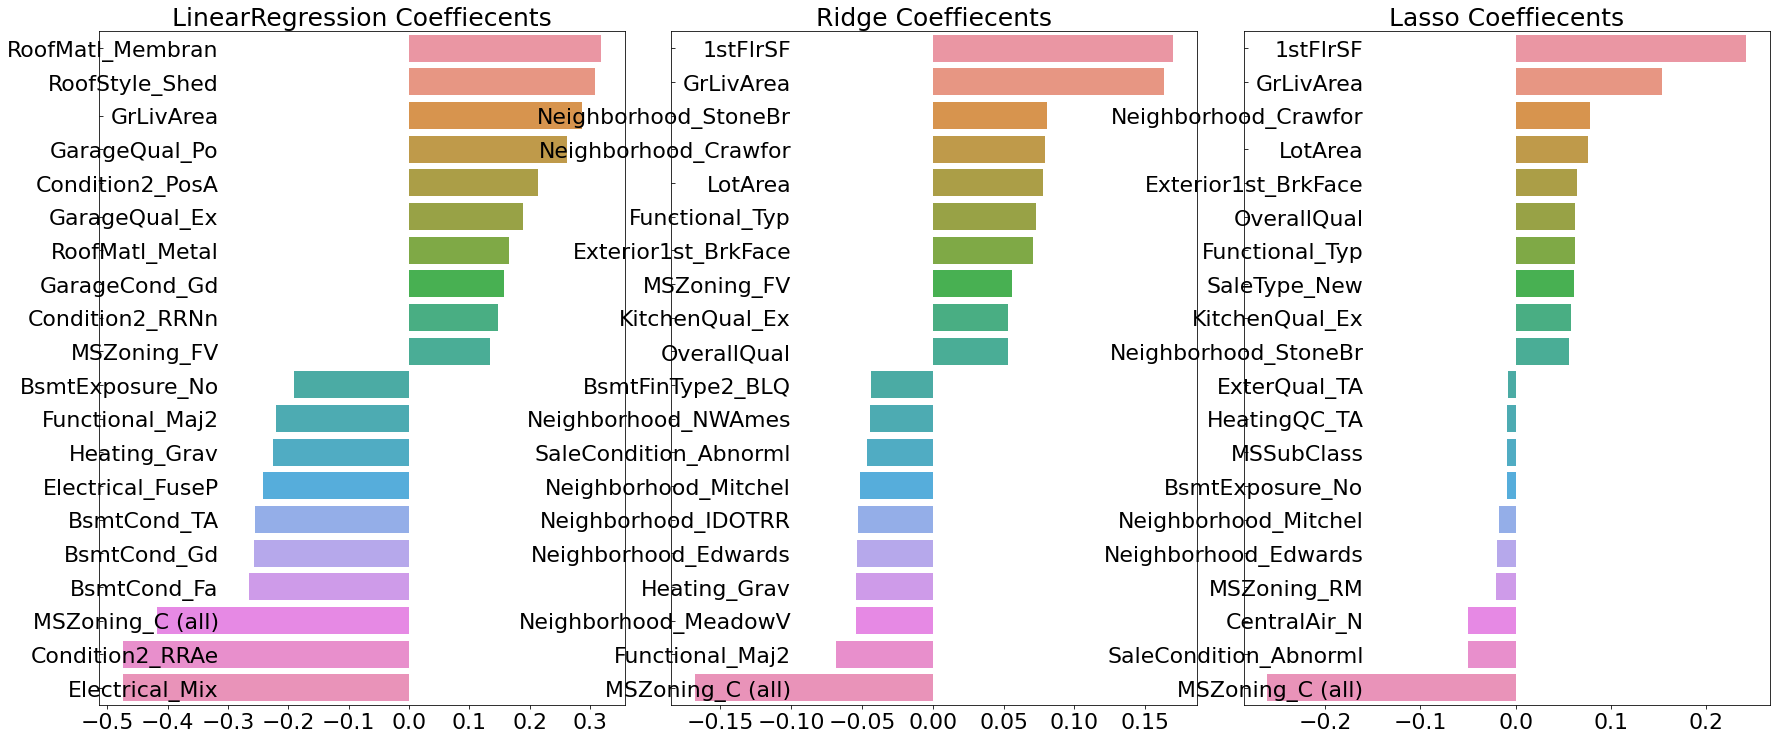

In [110]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
visualize_coefficient(models)

## 회귀 트리 모델 학습/예측/평가

이번에는 회귀 트리를 이용해 회귀 모델을 만들어 보겠다. XGBoost는 XGBRegressor 클래스를, LightGBM은 LGBMRegressor 클래스를 이용한다. XGBoost, LightGBM 모두 수행 시간이 오래 걸릴 수 있는 관계로 다음과 같은 하이퍼파라미터 설정을 미리 적용한 상태로 5 폴드 세트에 대한 평균 RMSE 값을 구하겠다.

In [113]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators': [1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값:0.1178, 최적 alpha:{'n_estimators': 1000}


XGBoost 회귀 트리를 적용했을 때 5 폴드 세트 평균 RMSE가 약 0.1178이다. 이번에는 LightGBM 회귀 트리를 적용해 보겠다.

In [114]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators': [1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값:0.1163, 최적 alpha:{'n_estimators': 1000}


LightGBM 적용 시 5폴드 세트 평균 RMSE가 약 0.1163이다. 이 모델의 피처 중요도를 시각화해 보겠다.

XGBRegressor  로그 변환된 RMSE: 0.107
LGBMRegressor  로그 변환된 RMSE: 0.104


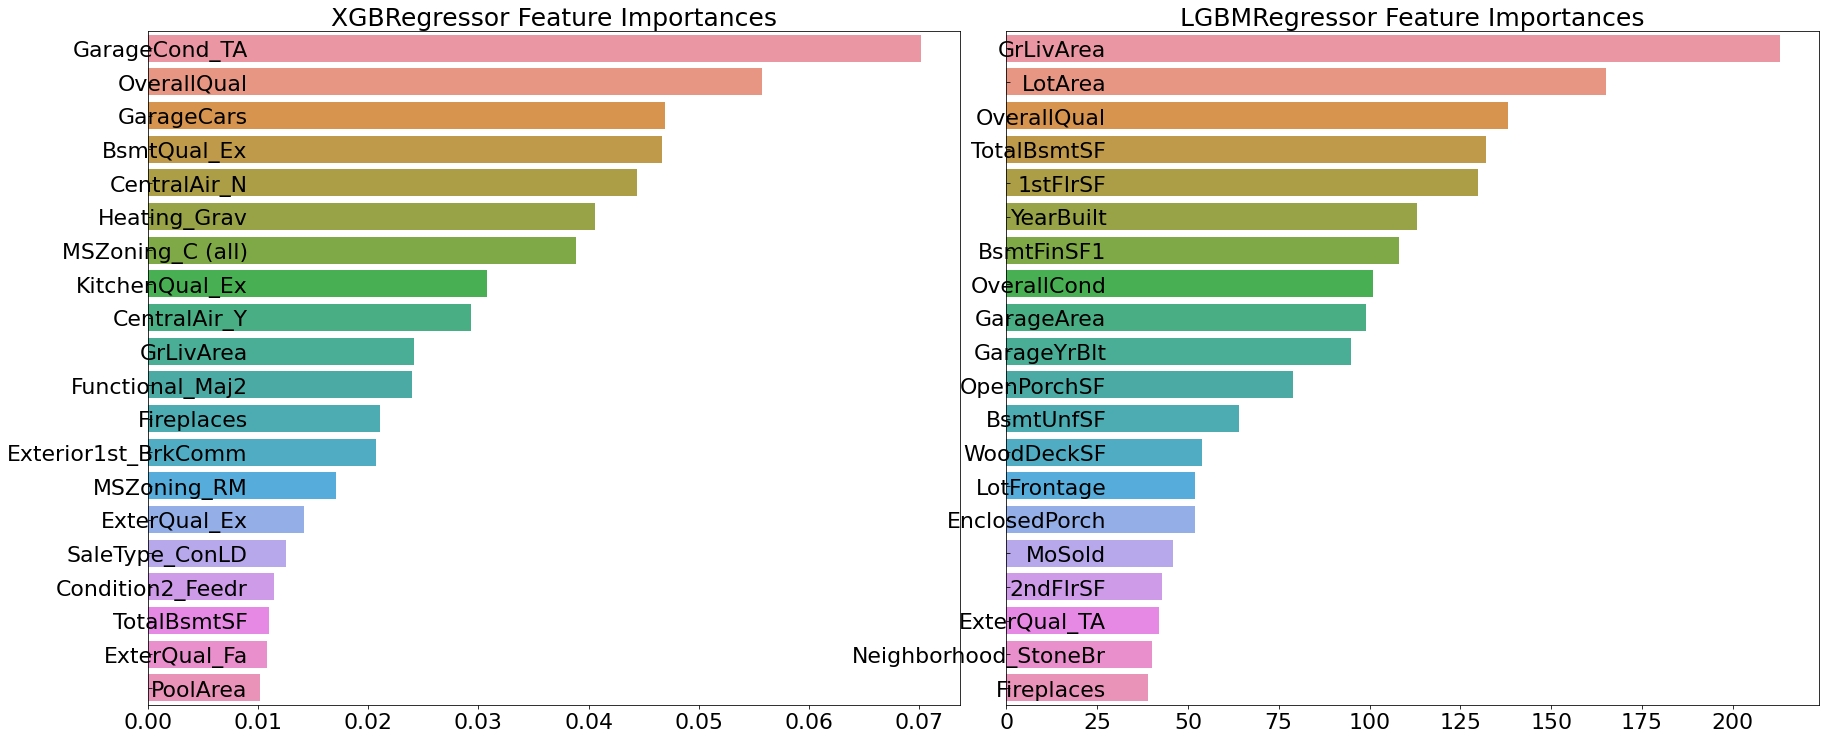

In [123]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
xgb_reg.fit(X_train, y_train)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
lgbm_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [xgb_reg, lgbm_reg]
get_rmses(models)

def visualize_coefficient(models):
    # 2개 회귀 트리의 피처 중요도 시각화를 위해 2개의 칼럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=2)
    fig.tight_layout()
    # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 피처 중요도 시각화.
    for i_num, model in enumerate(models):
        # ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정.
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        axs[i_num].tick_params(axis="y", direction="in", pad=-100)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
            
        ftr_importances_values = model.feature_importances_
        ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns)
        ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
        sns.barplot(x=ftr_top20, y=ftr_top20.index, ax=axs[i_num])

visualize_coefficient(models)

## 회귀 모델의 예측 결과 혼합을 통한 최종 예측

이번에는 개별 회귀 모델의 예측 결괏값을 혼합해 이를 기반으로 최종 회귀 값을 예측하겠다. 기본적으로 예측 결과 혼합은 매우 간단하다. 가령 A 모델과 B 모델, 두 모델의 예측값이 있다면 A 모델 예측값의 40%, B 모델 예측값의 60%를 더해서 최종 회귀 값으로 예측하는 것이다. A 회귀 모델 예측값이 [100, 80, 60]이고, B 회귀 모델의 예측값이 [120, 80, 50]이라면 최종 회귀 예측값은 [100x0.4 + 120x0.6, 80x0.4 + 80x0.6 + 60x0.4 + 50x0.6] = [112, 80, 54]가 된다. 앞에서 구한 릿지 모델과 라쏘 모델을 서로 혼합해 보겠다. 최종 혼합 모델, 개별 모델의 RMSE 값을 출력하는 <code>get_rmse_pred()</code> 함수를 생성하고 각 모델의 예측값을 계산한 뒤 개별 모델과 최종 혼합 모델의 RMSE를 구한다.

In [124]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE:: {1}'.format(key, rmse))
        
# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}

# 최종 혼합 모델, 개별 모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE:: 0.10007930884470516
Ridge 모델의 RMSE:: 0.10345177546603264
Lasso 모델의 RMSE:: 0.10024170460890032


최종 혼합 모델의 RMSE가 개별 모델보다 성능 면에서 약간 개선됐다. 릿지 모델 예측값에 0.4를 곱하고 라쏘 모델 예측값에 0.6을 곱한 뒤 더했다. 0.4나 0.6을 정하는 특별한 기준은 없다. 두 개 중 성능이 조금 좋은 쪽에 가중치를 약간 더 줬다. 이번에는 XGBoost나 LightGBM을 혼합해 결과를 살펴보겠다.

In [125]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}

get_rmse_pred(preds)

최종 혼합 모델의 RMSE:: 0.10170077353447762
XGBM 모델의 RMSE:: 0.10738295638346222
LGBM 모델의 RMSE:: 0.10382510019327311


XGBoost와 LightGBM의 혼합 모델의 RMSE가 개별 모델의 RMSE보다 조금 향상됐다.

## 스태킹 앙상블 모델을 통한 회귀 예측

먼저 스태킹 모델의 구현 방법을 다시 정리하겠다. 스태킹 모델은 두 종류의 모델이 필요하다. 첫 번째는 개별적인 기반 모델이고, 두 번째 이 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델이다. 스태킹 모델의 핵심은 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 코델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것이다.

최종 메타 모델이 학습할 피처 데이터 세트는 원본 학습 피처 세트로 학습한 개별 모델의 예측값을 스태킹 형태로 결합한 것이다. 개별 모델을 스태킹 모델로 제공하기 위해 데이터 세트를 생성하기 위한 <code>get_stacking_base_datasets()</code> 함수다.

In [132]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, ' model 시작 ')
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트: ', folder_counter, ' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr, y_tr)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 에측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)
    
    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

<code>get_stacking_base_datasets()</code>는 인자로 개별 기반 모델, 그리고 원래 사용되는 학습 데이터와 테스트용 피처 데이터를 입력 받는다. 함수 내에서는 개별 모델이 K-폴드 세트로 설정된 폴드 세트 내부에서 원본의 학습 데이터를 다시 추출해 학습과 예측을 수행한 뒤 그 결과를 저장한다. 저장된 예측 데이터는 추후에 메타 모델의 학습 피처 데이터 세트로 이용된다. 또한 함수 내에서 폴드 세트 내부 학습 데이터로 학습된 개별 모델이 인자로 입력된 원본 테스트 데이터를 예측한 뒤, 예측 결과를 평균해 테스트 데이터로 생성한다.

이제 <code>get_stacking_base_datasets()</code>를 모델별로 적용해 메타 모델이 사용할 학습 피처 데이터 세트와 테스트 피처 데이터 세트를 추출하겠다. 적용할 개별 모델은 릿지, 라쏘, XGBoost, LightGBM의 총 4개다.

In [133]:
# get_stacking_base_datasets()는 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환.
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base) 모델이 생성한 학습용/테스트용 데이터 반환.
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n ,y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


각 개별 모델이 반환하는 학습용 피처 데이터와 테스트용 피처 데이터 세트를 결합해 최종 메타 모델에 적용해 보겠다. 메타 모델은 별도의 라쏘 모델을 이용하며, 최종적으로 예측 및 RMSE를 측정한다.

In [134]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합.
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용.
meta_model_lasso = Lasso(alpha=0.0005)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측 및 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.09799152965189678


최종적으로 스태킹 회귀 모델을 적용한 결과, 테스트 데이터 세트에서 RMSE가 약 0.098로 현재까지 가장 좋은 성능 평가를 보여준다. 스태킹 모델은 분류뿐만 아니라 회귀에서 특히 효과적으로 사용될 수 있는 모델이다.